# Policy Iteration

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print('Load Packages')

Load Packages


# FrozenLake

In [2]:
env = gym.make('FrozenLake8x8-v1')

obs_space = env.observation_space
n_state = obs_space.n
print('Observation space')
print("Total {} states".format(n_state))

act_space = env.action_space
n_act = act_space.n
print('Action space')
print("Total {} actions".format(n_act))

Observation space
Total 64 states
Action space
Total 4 actions


# Define functions step by step

### Initial Policy $\pi_{0}(\cdot|s)$

Initial Policy Distribution:



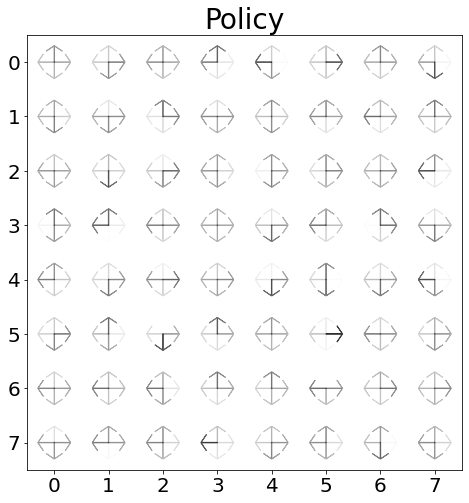

In [3]:
def plot_policy(policy,fig_title="Policy"):
    fig= plt.figure(figsize=(8,8))
    ax = plt.axes()
    ax.set_xticks(list(range(8)))
    ax.set_yticks(list(range(8)))
    plt.imshow(np.ones((8,8,3)))
    plt.title(fig_title,fontdict={'fontsize':28})  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="k",alpha=policy[s][0],width=0.01,head_width=0.3,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="k",alpha=policy[s][1],width=0.01,head_width=0.3,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="k",alpha=policy[s][2],width=0.01,head_width=0.3,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="k",alpha=policy[s][3],width=0.01,head_width=0.3,head_length=0.1,overhang=1)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.show()
    
policy = np.random.uniform(size=(n_state,n_act)) # sample random number between 0 and 1
policy = policy/np.sum(policy,axis=1,keepdims=True) # make it sum to 1

np.set_printoptions(precision=3,suppress=True)
print("Initial Policy Distribution:\n")
plot_policy(policy)

## Policy Evaluation

In this step, value function for fixed policy $\pi$ is computed. 
We will mainly use Bellman expectation equation for $V_{\pi}$:

$V_{\pi}(s)=\sum_{a}\pi(a|s)\sum_{s'}[r(s,a,s')+\gamma V_{\pi}(s')]P(s'|s,a)$

Policy evaluation for random policy

Value of current policy:


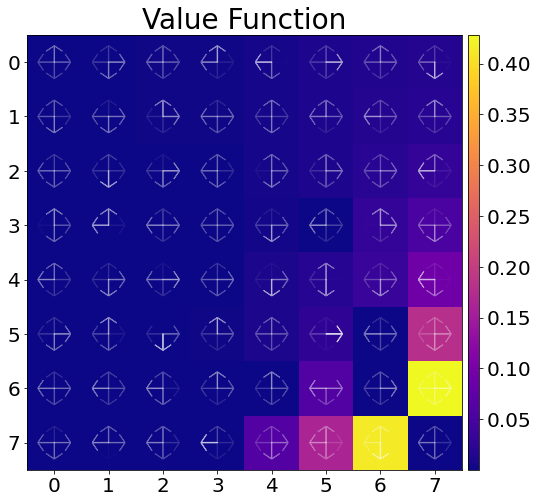

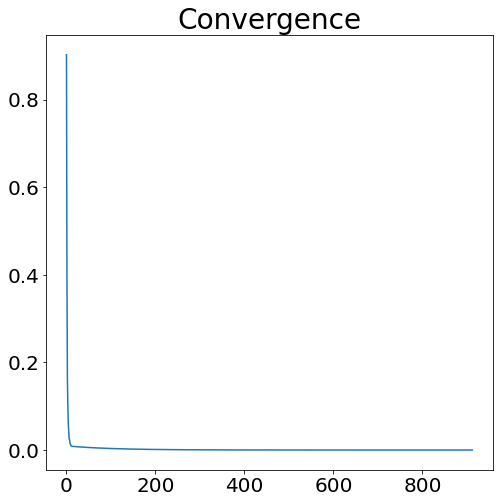

In [4]:
def policy_evaluation(env, policy, gamma = 0.99, epsilon = 1e-6):
    '''
    env : gym environment
    gamma : discount factor
    epsilon : terminal condition
    '''
    
    # Extract environment information
    obs_space = env.observation_space
    n_state = obs_space.n
    P = env.unwrapped.P    
    
    # Random initial
    v = np.random.uniform(size=(n_state,1))
    error_list = []
    
    while True:
        v_prime = np.zeros((n_state,))
        for s in P.keys(): # For all states s, update v(s)
            for a in P[s].keys(): # For all actions a
                for prob, next_s, reward, done in P[s][a]: # For all possible transitions (s,a,s')
                    v_prime[s] += (reward + gamma*v[next_s])*prob*policy[s][a]    
        
        dist = np.max(np.abs(v-v_prime))
        error_list.append(dist)
        v = v_prime
        if dist < epsilon:
            break
    return v, error_list

def plot_results(policy, value, fig_title="Value Function"):
    fig= plt.figure(figsize=(8,8))
    ax = plt.axes()
    ax.set_xticks(list(range(8)))
    ax.set_yticks(list(range(8)))
    im = plt.imshow(np.reshape(value,(8,8)),cmap='plasma')
    plt.title(fig_title,fontdict={'fontsize':28})  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="w",alpha=policy[s][0],width=0.01,head_width=0.3,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="w",alpha=policy[s][1],width=0.01,head_width=0.3,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="w",alpha=policy[s][2],width=0.01,head_width=0.3,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="w",alpha=policy[s][3],width=0.01,head_width=0.3,head_length=0.1,overhang=1)
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=20)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.show()

def plot_errors(_error_list):
    fig= plt.figure(figsize=(8,8))
    ax = plt.axes()
    
    plt.title("Convergence",fontdict={'fontsize':28})  
    plt.plot(_error_list)
        
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.show()
    
if __name__ == '__main__':
    print('Policy evaluation for random policy\n')
    value, error_list = policy_evaluation(env, policy, gamma = 0.99, epsilon = 1e-6)
    print('Value of current policy:')
    plot_results(policy, value)
    plot_errors(error_list)

### Policy Improvement

In this step, we update policy distribution using the value function computed by policy evaluation.
A new policy distribution is updated greedly as follows:

$Q_{\pi_{i}}(s,a)=\sum_{s'}[r(s,a,s')+\gamma V_{\pi_{i}}(s')]P(s'|s,a)$

$\pi_{i+1} = \arg\max_{a} Q_{\pi_{i}}(s,a)$

Policy improvement

Improved Policy:


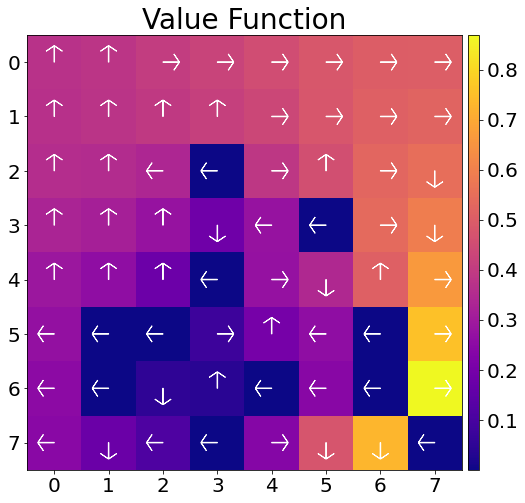

In [5]:
def policy_improvement(env, v, gamma = 0.99):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    P = env.unwrapped.P    
    q = np.zeros((n_state,n_act))
    
    for s in P.keys():# For all states s,
        for a in P[s].keys():# For all actions a
            for prob, next_s, reward, done in P[s][a]:
                q[s,a] += (reward + gamma*v[next_s])*prob # Compute q[s,a] from v[s'], keep adding r[s,a,s']+gamma*v[s'] for all transition
                    
    policy = np.zeros((n_state,n_act))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1
    
    return policy

if __name__ == '__main__':
    print('Policy improvement\n')
    imp_policy = policy_improvement(env, value)
    imp_value, error_list = policy_evaluation(env, imp_policy, gamma = 0.99, epsilon = 1e-6)
    print('Improved Policy:')
    plot_results(imp_policy, imp_value)

### Policy Iteration

Policy iteration algorithm consists of four steps:

(1) Initial policy distribution is randomly initialized

(2) Value function for current policy is computed by policy evaluation

(3) Policy distribution is greedily updated using value function from (2)

(4) If policy distribution doesn't change, then stop. Othrewise, repeat (1) ~ (3)

Policy Iteration
Computation Time : 2.60


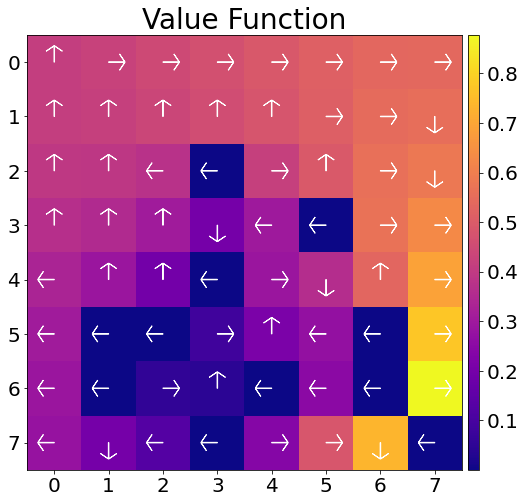

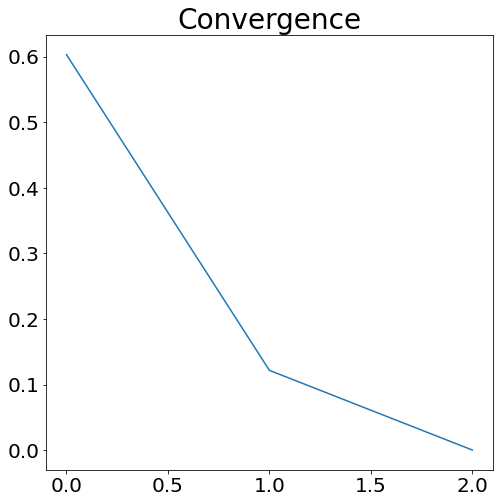

In [6]:
def policy_iteration(env):
    policy = np.random.uniform(size=(n_state,n_act))
    policy = policy/np.sum(policy,axis=1,keepdims=True)
    value, _ = policy_evaluation(env, policy) # Evaluate value of current policy
    
    error_list = []
    while True:
        policy_prime = policy_improvement(env, value) # Find greedy policy
        value_prime, _ = policy_evaluation(env, policy_prime)
        
        dist = np.max(np.abs(value-value_prime))
        error_list.append(dist)
        if (policy == policy_prime).all(): # If policy doesn't change, stop
            break
        policy = policy_prime # update new policy
        value = value_prime
        
    return policy, value, error_list
    
if __name__=='__main__': 
    print("Policy Iteration")
    import time
    start = time.time()
    policy, value, error_list = policy_iteration(env)
    print("Computation Time : %.2f"%(time.time() - start))
    plot_results(policy, value)
    plot_errors(error_list)

### Run optimal policy

In [7]:
obs = env.reset()
for t in range(10000):
    print('t = %d'%t)
    env.render()
    print('')
    action = np.random.choice(n_act, 1, p=policy[obs][:])[0]
    next_obs, reward, done, info = env.step(action)
    obs = next_obs
    if done:
        break
env.render()
env.close()

t = 0

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 1
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 2
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 3
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 4
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 5
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 6
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 7
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 8
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 9
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 10
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

t = 11
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFH

# Numpy Version

Better implementation using numpy functions

This is computationally faster than above implementation

For loop is replaced with numpy native functions, such as 'np.tile' and 'np.sum'

Policy Iteration Compact
Computation Time : 0.25



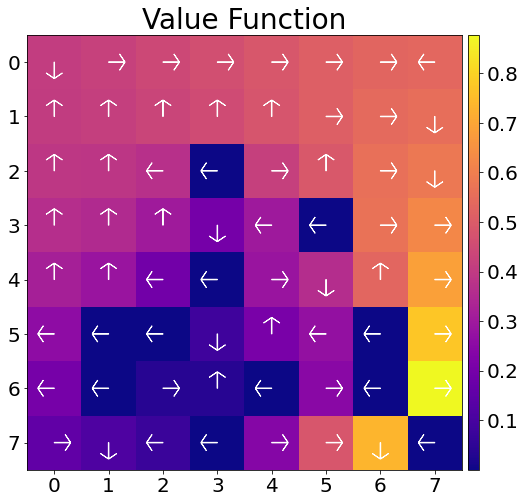

In [8]:
def policy_evaluation_np(env, P, r, policy, gamma = 0.99, epsilon = 1e-6):
    
    # Extract environment information
    obs_space = env.observation_space
    act_space = env.action_space
    n_state = obs_space.n
    n_act = act_space.n
        
    # Random initial
    v = np.random.uniform(size=(n_state,))
    
    while True:
        v_prime = np.sum(policy*np.sum((r+gamma*np.tile(v[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2),axis=1)
        dist = np.max(np.abs(v-v_prime))
        v = v_prime
        if dist < epsilon:
            break
    return v

def policy_improvement_np(env, P, r, v, gamma = 0.99):
    obs_space = env.observation_space
    act_space = env.action_space
    n_state = obs_space.n
    n_act = act_space.n
    
    q = np.sum((r+gamma*np.tile(v[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2)
                    
    policy = np.zeros((n_state,n_act))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1
    
    return policy

def policy_iteration_np(env):
    policy = np.random.uniform(size=(n_state,n_act))
    policy = policy/np.sum(policy,axis=1,keepdims=True)
    P = np.zeros((n_state,n_act,n_state))
    r = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward
            
    value = policy_evaluation_np(env, P, r, policy) # Evaluate value of current policy
    while True:
        policy_prime = policy_improvement_np(env, P, r, value) # Find greedy policy
        value_prime = policy_evaluation_np(env, P, r, policy_prime) # Evaluate value of current policy

        dist = np.max(np.abs(value-value_prime))
        error_list.append(dist)
        if (policy == policy_prime).all(): # If policy doesn't change, stop
            break
        policy = policy_prime # update new policy
        value = value_prime
    return policy, value

if __name__=='__main__': 
    print("Policy Iteration Compact")
    import time
    start = time.time()
    policy, value = policy_iteration_np(env)
    print("Computation Time : %.2f"%(time.time() - start))
    print('')
    plot_results(policy, value)

### Modified Policy Iteration

Modified Policy Iteration
Computation Time : 1.16



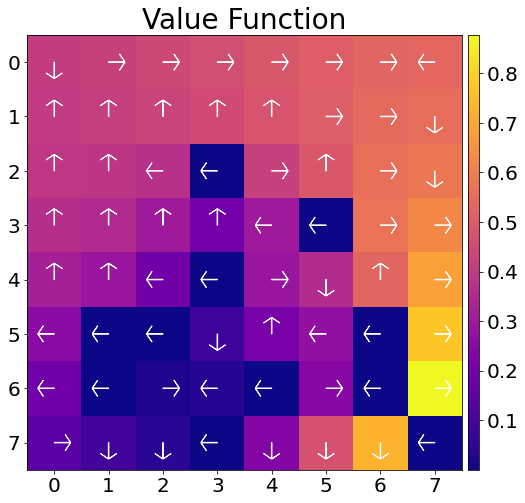

In [9]:
def approximate_policy_evaluation_np(env, P, r, policy, n_iter = 10, gamma = 0.99, epsilon = 1e-6):
    
    # Extract environment information
    obs_space = env.observation_space
    act_space = env.action_space
    n_state = obs_space.n
    n_act = act_space.n
        
    # Random initial
    v = np.random.uniform(size=(n_state,))
    for k in range(n_iter):
        v_prime = np.sum(policy*np.sum((r+gamma*np.tile(v[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2),axis=1)
        dist = np.max(np.abs(v-v_prime))
        v = v_prime
        if dist < epsilon:
            break
    return v

def policy_improvement_np(env, P, r, v, gamma = 0.99):
    obs_space = env.observation_space
    act_space = env.action_space
    n_state = obs_space.n
    n_act = act_space.n
    
    q = np.sum((r+gamma*np.tile(v[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2)
                    
    policy = np.zeros((n_state,n_act))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1
    
    return policy

def modified_policy_iteration_np(env, n_iter = 100):
    policy = np.random.uniform(size=(n_state,n_act))
    policy = policy/np.sum(policy,axis=1,keepdims=True)
    P = np.zeros((n_state,n_act,n_state))
    r = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward
            
    approx_value = approximate_policy_evaluation_np(env, P, r, policy, n_iter) # Evaluate value of current policy
    while True:
        policy_prime = policy_improvement_np(env, P, r, approx_value) # Find greedy policy
        approx_value_prime = approximate_policy_evaluation_np(env, P, r, policy_prime, n_iter) # Evaluate value of current policy

        if (policy == policy_prime).all(): # If policy doesn't change, stop
            break
        policy = policy_prime # update new policy
        approx_value = approx_value_prime
        
    value = policy_evaluation_np(env, P, r, policy, gamma = 0.99)
    return policy, value

if __name__=='__main__': 
    print("Modified Policy Iteration")
    import time
    start = time.time()
    policy, value = modified_policy_iteration_np(env)
    print("Computation Time : %.2f"%(time.time() - start))
    print('')
    plot_results(policy, value)